In [1]:
import spacy
from spacy import displacy
import en_core_web_sm
nlp = en_core_web_sm.load()

In [24]:
text = nlp(
'Apple CEO Tim Cook Introduces 2 New iPhones at Cupertino Flint Center'
)
displacy.render(text, style = 'ent', jupyter=True)

In [3]:
#Import packages
import numpy as np
from utils.validation import compute_f1
from keras.models import Model, load_model
from keras.layers import TimeDistributed, Conv1D, Dense, Embedding, Input, Dropout, LSTM, Bidirectional, MaxPooling1D, \
    Flatten, concatenate
from utils.prepro import readfile, createBatches, createMatrices, iterate_minibatches, addCharInformation, padding , plot_graphs
from keras.utils import plot_model 
from keras.utils import Progbar
from keras.initializers import RandomUniform
from keras.optimizers import SGD, Nadam
import matplotlib.pyplot as plt
from utils.ner import Parser
import nltk 
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Z003SFDm\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
epochs = 80

In [5]:
trainSentences = readfile("data/train.txt")
devSentences = readfile("data/dev.txt")
testSentences = readfile("data/test.txt")

trainSentences = addCharInformation(trainSentences)
devSentences = addCharInformation(devSentences)
testSentences = addCharInformation(testSentences)

In [6]:
labelSet = set()
words = {}

for dataset in [trainSentences, devSentences, testSentences]:
    for sentence in dataset:
        for token,char,label in sentence:
            labelSet.add(label)
            words[token.lower()] = True

# :: Create a mapping for the labels ::
label2Idx = {}
for label in labelSet:
    label2Idx[label] = len(label2Idx)

# :: Hard coded case lookup ::
case2Idx = {'numeric': 0, 'allLower':1, 'allUpper':2, 'initialUpper':3, 'other':4, 'mainly_numeric':5, 'contains_digit': 6, 'PADDING_TOKEN':7}
caseEmbeddings = np.identity(len(case2Idx), dtype='float32')


# :: Read in word embeddings ::
word2Idx = {}
wordEmbeddings = []

fEmbeddings = open("embeddings/glove.6B.100d.txt", encoding="utf-8")

for line in fEmbeddings:
    split = line.strip().split(" ")
    word = split[0]
    
    if len(word2Idx) == 0: #Add padding+unknown
        word2Idx["PADDING_TOKEN"] = len(word2Idx)
        vector = np.zeros(len(split)-1) #Zero vector vor 'PADDING' word
        wordEmbeddings.append(vector)
        
        word2Idx["UNKNOWN_TOKEN"] = len(word2Idx)
        vector = np.random.uniform(-0.25, 0.25, len(split)-1)
        wordEmbeddings.append(vector)

    if split[0].lower() in words:
        vector = np.array([float(num) for num in split[1:]])
        wordEmbeddings.append(vector)
        word2Idx[split[0]] = len(word2Idx)
        
wordEmbeddings = np.array(wordEmbeddings)

In [18]:
char2Idx = {"PADDING":0, "UNKNOWN":1}
for c in " 0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ.,-_()[]{}!?:;#'\"/\\%$`&=*+@^~|":
    char2Idx[c] = len(char2Idx)

train_set = padding(createMatrices(trainSentences,word2Idx,  label2Idx, case2Idx,char2Idx))
dev_set = padding(createMatrices(devSentences,word2Idx, label2Idx, case2Idx,char2Idx))
test_set = padding(createMatrices(testSentences, word2Idx, label2Idx, case2Idx,char2Idx))

idx2Label = {v: k for k, v in label2Idx.items()}
np.save("models/idx2Label.npy",idx2Label)
np.save("models/word2Idx.npy",word2Idx)

train_batch,train_batch_len = createBatches(train_set)
dev_batch,dev_batch_len = createBatches(dev_set)
test_batch,test_batch_len = createBatches(test_set)

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
char_input (InputLayer)         [(None, None, 52)]   0                                            
__________________________________________________________________________________________________
char_embedding (TimeDistributed (None, None, 52, 30) 2850        char_input[0][0]                 
__________________________________________________________________________________________________
dropout (Dropout)               (None, None, 52, 30) 0           char_embedding[0][0]             
__________________________________________________________________________________________________
time_distributed (TimeDistribut (None, None, 52, 30) 2730        dropout[0][0]                    
_______________________________________________________________________________________

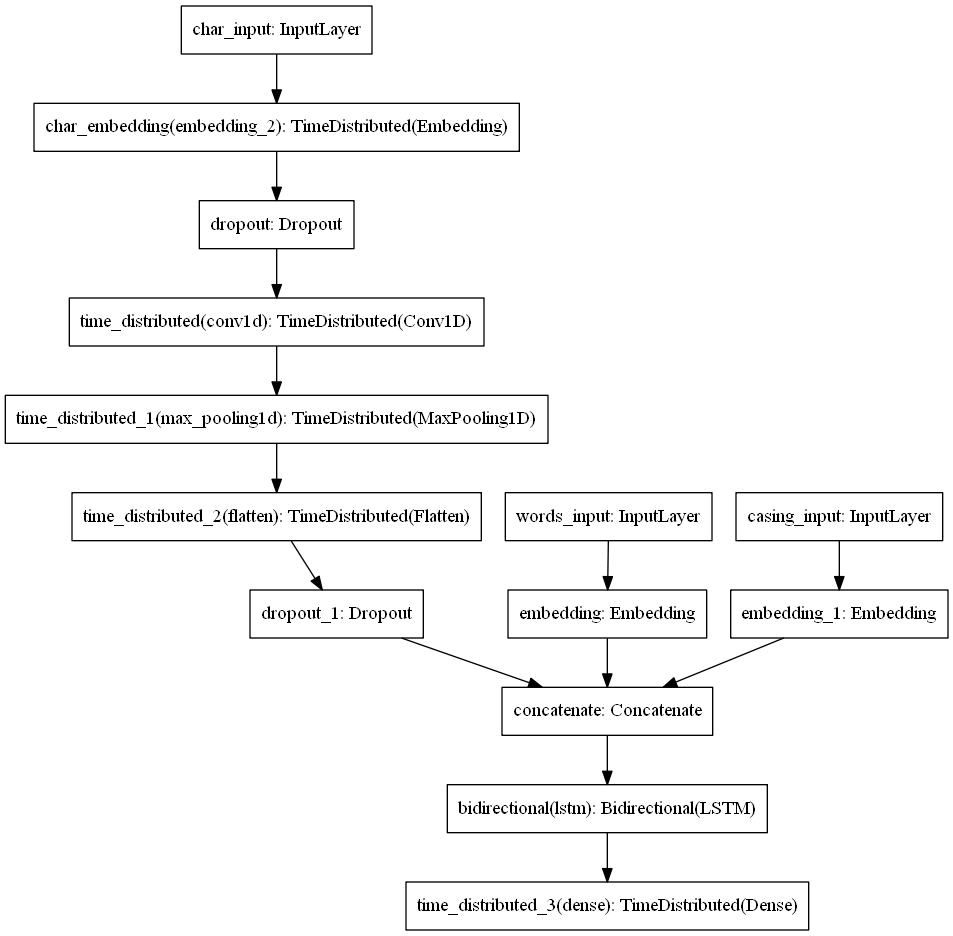

In [8]:
words_input = Input(shape=(None,),dtype='int32',name='words_input')
words = Embedding(input_dim=wordEmbeddings.shape[0], output_dim=wordEmbeddings.shape[1],  weights=[wordEmbeddings], trainable=False)(words_input)
casing_input = Input(shape=(None,), dtype='int32', name='casing_input')
casing = Embedding(output_dim=caseEmbeddings.shape[1], input_dim=caseEmbeddings.shape[0], weights=[caseEmbeddings], trainable=False)(casing_input)
character_input=Input(shape=(None,52,),name='char_input')
embed_char_out=TimeDistributed(Embedding(len(char2Idx),30,embeddings_initializer=RandomUniform(minval=-0.5, maxval=0.5)), name='char_embedding')(character_input)
dropout= Dropout(0.5)(embed_char_out)
conv1d_out= TimeDistributed(Conv1D(kernel_size=3, filters=30, padding='same',activation='tanh', strides=1))(dropout)
maxpool_out=TimeDistributed(MaxPooling1D(52))(conv1d_out)
char = TimeDistributed(Flatten())(maxpool_out)
char = Dropout(0.5)(char)
output = concatenate([words, casing,char])
output = Bidirectional(LSTM(200, return_sequences=True, dropout=0.50, recurrent_dropout=0.25))(output)
output = TimeDistributed(Dense(len(label2Idx), activation='softmax'))(output)
model = Model(inputs=[words_input, casing_input,character_input], outputs=[output])
model.compile(loss='sparse_categorical_crossentropy', optimizer='nadam',metrics=['accuracy'])
model.summary()
plot_model(model, to_file='model.png',show_layer_names=True)


In [9]:
training_accuracy=[]
training_loss=[]
test_accuracy=[] 
test_loss=[]

for epoch in range(epochs):    
    print("Epoch %d/%d"%(epoch,epochs))
    a = Progbar(len(train_batch_len))
    for i,batch in enumerate(iterate_minibatches(train_batch,train_batch_len)):
        train_labels, train_tokens, train_casing,train_char = batch       
        out=model.train_on_batch([train_tokens, train_casing,train_char], train_labels)
        a.update(i)   
    a.update(i+1) 
    b = Progbar(len(dev_batch_len))
    for i,test_batch in enumerate(iterate_minibatches(dev_batch,dev_batch_len)):
        labels, tokens, casing,char = test_batch       
        out1=model.test_on_batch([tokens, casing,char], labels)
        b.update(i)
    b.update(i+1)
    training_loss.append(out[0])
    training_accuracy.append(out[1])
    test_loss.append(out1[0])
    test_accuracy.append(out1[1])
    print('training accuracy',out[1]) 
    print('test accuracy',out1[1]) 
    print('training loss',out[0])
    print('test loss',out1[0])
model.save("models/model.h5")

Epoch 0/80
65/65 [==============================] - 7s 107ms/step
training accuracy 0.8938053250312805
test accuracy 0.7614678740501404
training loss 0.2942441999912262
test loss 0.6048042178153992
Epoch 1/80
65/65 [==============================] - 5s 76ms/step
training accuracy 0.9557521939277649
test accuracy 0.9541284441947937
training loss 0.16824978590011597
test loss 0.12949047982692719
Epoch 2/80
65/65 [==============================] - 4s 64ms/step
training accuracy 0.991150438785553
test accuracy 0.9816513657569885
training loss 0.046338535845279694
test loss 0.054801926016807556
Epoch 3/80
65/65 [==============================] - 4s 54ms/step
training accuracy 0.991150438785553
test accuracy 0.9816513657569885
training loss 0.042574912309646606
test loss 0.03937309980392456
Epoch 4/80
65/65 [==============================] - 4s 61ms/step
training accuracy 1.0
test accuracy 0.9908257126808167
training loss 0.023372063413262367
test loss 0.029624126851558685
Epoch 5/80
65/65 [

65/65 [==============================] - 5s 73ms/step
training accuracy 1.0
test accuracy 1.0
training loss 0.000196776760276407
test loss 0.0008773364825174212
Epoch 36/80
65/65 [==============================] - 4s 69ms/step
training accuracy 1.0
test accuracy 1.0
training loss 0.0004188544407952577
test loss 0.0008520812261849642
Epoch 37/80
65/65 [==============================] - 5s 73ms/step
training accuracy 1.0
test accuracy 1.0
training loss 0.0008686408982612193
test loss 0.0008162314770743251
Epoch 38/80
65/65 [==============================] - 4s 63ms/step
training accuracy 1.0
test accuracy 1.0
training loss 0.0005347027909010649
test loss 0.0005558502743951976
Epoch 39/80
65/65 [==============================] - 5s 81ms/step
training accuracy 1.0
test accuracy 1.0
training loss 0.0004398325108923018
test loss 0.00058905960759148
Epoch 40/80
65/65 [==============================] - 4s 60ms/step
training accuracy 1.0
test accuracy 1.0
training loss 0.00014662303146906197
te

65/65 [==============================] - 4s 60ms/step
training accuracy 1.0
test accuracy 1.0
training loss 1.82059684448177e-05
test loss 0.00012031284859403968
Epoch 72/80
65/65 [==============================] - 5s 70ms/step
training accuracy 1.0
test accuracy 1.0
training loss 7.379040653177071e-06
test loss 0.0001046040779328905
Epoch 73/80
65/65 [==============================] - 3s 54ms/step
training accuracy 1.0
test accuracy 1.0
training loss 0.00022380707378033549
test loss 0.0001104050679714419
Epoch 74/80
65/65 [==============================] - 3s 53ms/step
training accuracy 1.0
test accuracy 1.0
training loss 3.4281631087651476e-05
test loss 0.0001659969857428223
Epoch 75/80
65/65 [==============================] - 4s 58ms/step
training accuracy 1.0
test accuracy 1.0
training loss 3.3268854167545214e-05
test loss 8.517690002918243e-05
Epoch 76/80
65/65 [==============================] - 4s 65ms/step
training accuracy 1.0
test accuracy 1.0
training loss 4.4287113269092515e

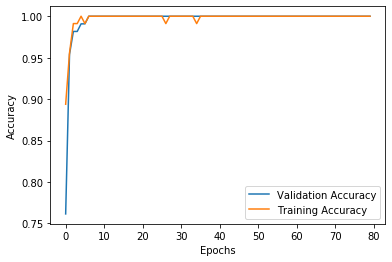

In [13]:

plt.plot(test_accuracy, label = "Validation Accuracy")
plt.plot(training_accuracy, label = "Training Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

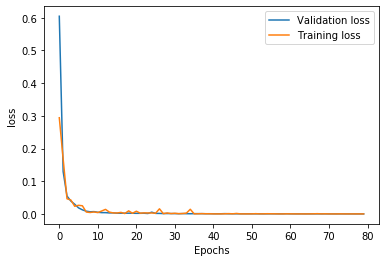

In [14]:

plt.plot(test_loss, label = "Validation loss")
plt.plot(training_loss, label = "Training loss")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.legend()

plt.show()

In [19]:
#   Performance on test dataset       
predLabels, correctLabels = tag_dataset(test_batch)        
pre_test, rec_test, f1_test= compute_f1(predLabels, correctLabels, idx2Label)
print("Test-Data: Prec: %.3f, Rec: %.3f, F1: %.3f" % (pre_test, rec_test, f1_test))

3453/3453 [==============================] - 200s 58ms/step
Test-Data: Prec: 0.889, Rec: 0.898, F1: 0.893


In [15]:
def tag_dataset(dataset):
    correctLabels = []
    predLabels = []
    b = Progbar(len(dataset))
    for i,data in enumerate(dataset):    
        tokens, casing,char, labels = data
        tokens = np.asarray([tokens])     
        casing = np.asarray([casing])
        char = np.asarray([char])
        pred = model.predict([tokens, casing,char], verbose=False)[0]   
        pred = pred.argmax(axis=-1) #Predict the classes            
        correctLabels.append(labels)
        predLabels.append(pred)
        b.update(i)
    b.update(i+1)
    return predLabels, correctLabels

In [25]:
p = Parser()

p.load_models("models/")

p.predict("Apple CEO Tim Cook Introduces 2 New iPhones at Cupertino Flint Center")

[('Apple', 'O'),
 ('CEO', 'O'),
 ('Tim', 'B-PER'),
 ('Cook', 'I-PER'),
 ('Introduces', 'O'),
 ('2', 'O'),
 ('New', 'B-ORG'),
 ('iPhones', 'I-ORG'),
 ('at', 'O'),
 ('Cupertino', 'B-ORG'),
 ('Flint', 'I-LOC'),
 ('Center', 'I-LOC')]